# Problem 1: Gradient-based variational inference

Let us consider the exact same model and data as in the previous exercise set:
\begin{align*}
x_n &\sim \text{Poisson}(uv),\\
u &\sim \text{Gamma}(6, 1),\\
v &\sim \text{Gamma}(3, 3).
\end{align*}
with the same data $\mathbf{x}=[5, 3, 9, 13, 5, 3, 5, 1, 2, 7, 6, 5, 6, 7, 4]$.

Now we use gradient-based methods to learn variational approximation for the posterior. 

Write code that:
1. Specifies the approximation using suitable pytorch.distribution
2. Evaluates the ELBO by using $M$ samples drawn from the approximation with .rsample()
3. Optimizes ELBO wrt the parameters of the approximation
4. Plots the approximation on top of Gibbs samples
5. Plots convergence of the ELBO estimate (note that with small $M$ this may be somewhat noisy). Use this plot to check that your optimizer actually has converged to a good solution.

Use the code to try out alternative models and approximations. For each of the three alternatives below, always show both the convergence curve and the resulting posterior approximation and **explain what you see**.
1. Use the same approximation family as before, so that $q(u,v)$ is a product of two gamma distributions. Do you get the same result as with CAVI?
2. Use multivariate normal approximation, so that $q(u,v)$ is a bivariate normal distribution. Explain what changed.
3. Change the prior $p(u,v)$ from product of two gamma distributions to product of two half-normal distributions with scales of your own choosing. Explain what happens.

HINTS:
1. https://pytorch.org/docs/stable/distributions.html helps with the distribution syntax etc.
2. You can use any $M$, but probably it is best to avoid very small ones. It is a good idea to quickly explore how the estimate behaves as a function of $M$.
3. The easiest way to parameterize the multivariate normal is to use some 2x2 matrix $A$ as learnable parameters but then give "L = torch.tril(A)" as the Cholesky parameter for the multivariate normal distribution. We have one extra parameter in $A$ that is never optimized or used (the top right corner), but that does not matter.
4. Be careful with bounds: You have positivity requirement for two things here, for the **parameters of the approximation terms** (for gamma approximation) and additionally for **the samples u and v drawn from the approximation** (for the normal approximation that could result in negative samples). You can, for example, use "torch.nn.functional.softplus(alpha_unconstrained)" as the alpha-parameter in a gamma distribution, and you can truncate the samples from the normal distribution to a small positive constant or push those also through softplus. The former is always valid but the latter is strictly speaking wrong as we then use truncated normal as approximation, but we can ignore this problem here for simplicity.
5. It is possible to write general code that directly supports arbitrary distributions, but that is quite tedious. You can definitely have separate copies of your code for the different choices of $q(u,v)$ if that is easier -- that's what I will be doing in model solutions anyway.
6. You already know the optimal solution for the gamma approximation based on Exercise 3. The values are quite large, so you might want to also initialize your approximation with numbers of similar magnitude to make the optimization problem a bit easier.

The cell below again has the model definition and Gibbs sampler for ease of result presentation.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

u_alpha = 6.
u_beta = 1.
v_alpha = 3.
v_beta = 3.

x = np.array([5,3,9,13,5,3,5,1,2,7,6,5,6,7,4])
N = len(x)

# Priors
u_prior = stats.gamma(u_alpha, scale=1./u_beta)
v_prior = stats.gamma(v_alpha, scale=1./v_beta)

def log_density(data, u, v):
    likelihood = stats.poisson(u*v)
    return np.sum(likelihood.logpmf(data)) + u_prior.logpdf(u) + v_prior.logpdf(v)

def Gibbs(x, u, v, T):
    # Storage for samples
    samples = [u, v]
    sumx = sum(x)
    N = len(x)
    for t in range(T):
        # Sample u conditional on v and data
        log_lambda_term = sumx + u_alpha
        lambda_term = N*v + u_beta
        u = np.random.gamma(log_lambda_term, scale = 1.0 / lambda_term)
        
        # Sample v conditional on u and data
        log_lambda_term = sumx + v_alpha
        lambda_term = N*u + v_beta
        v = np.random.gamma(log_lambda_term, scale = 1.0 / lambda_term)

        samples = np.vstack([samples, [u, v]])
    return samples

## Gamma product approximation

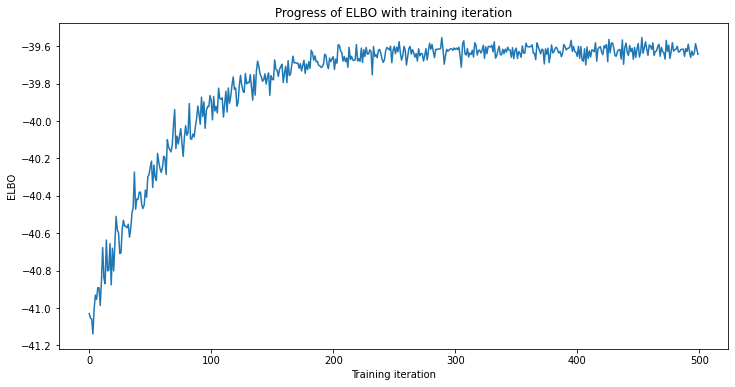

u mean estimate: 5.753475
v mean estimate: 0.941159


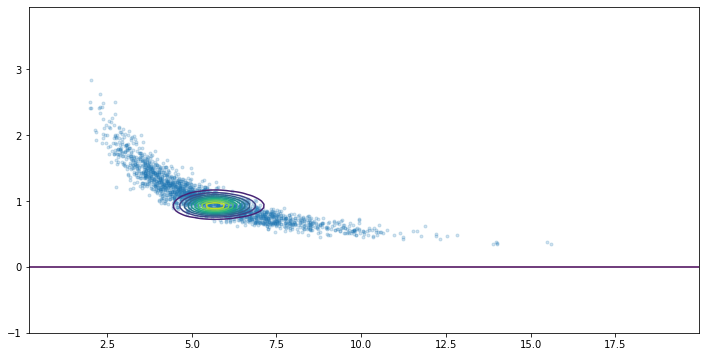

In [2]:
import torch
from torch.nn.functional import softplus as sp

# Define data and the optimization problem
data = torch.tensor(x).reshape((1, N))
parameters = torch.nn.Parameter(torch.tensor([86., 13., 87., 89.], requires_grad=True)) # Set also some initial values here
opt = torch.optim.Adam([parameters], lr=1e-2)
M = 1000
nIter = 500

# Priors
u_prior = torch.distributions.Gamma(u_alpha, u_beta)
v_prior = torch.distributions.Gamma(v_alpha, v_beta)

def log_density(data, u, v):
    likelihood = torch.distributions.Poisson(u*v)
    return torch.sum(likelihood.log_prob(data), axis=1) + u_prior.log_prob(u) + v_prior.log_prob(v)

ELBOS = list()
for i in range(nIter):
    opt.zero_grad()

    # Define approximation
    q_u = torch.distributions.Gamma(sp(parameters[0]), sp(parameters[1]))
    q_v = torch.distributions.Gamma(sp(parameters[2]), sp(parameters[3]))

    # Obtain samples
    u = q_u.rsample((M, 1))
    v = q_v.rsample((M, 1))
    
    # Compute ELBO
    ELBO = torch.mean( log_density(data, u, v) - (q_u.log_prob(u) + q_v.log_prob(v)) )
    
    # We need a minimization problem but ELBO is to be maximized
    loss = -ELBO
    loss.backward()
    ELBOS.append(ELBO.item())
    opt.step()
    
# Plotting goes here
# 1. Convergence plot
# 2. Illustration of the posterior
plt.plot(ELBOS)
plt.title("Progress of ELBO with training iteration")
plt.xlabel("Training iteration")
plt.ylabel("ELBO")
plt.show()

# Mean estimates
u_me = u.mean()
v_me = v.mean()

# Convert to np for plotting
parameters = parameters.detach().numpy()
u_me = u_me.detach().numpy()
v_me = v_me.detach().numpy()

print("u mean estimate:", u_me)
print("v mean estimate:",v_me)

ugrid = np.arange(0.2,20,0.05)
vgrid = np.arange(-1,4,0.05)
uset, vset = np.meshgrid(ugrid, vgrid)

# For the plotting you can get the density with something like the following, assuming your q_u and q_v are common distributions
pdf_VI = (stats.gamma(parameters[0], scale=1./parameters[1]).pdf(uset) * stats.gamma(parameters[2], scale=1./parameters[3]).pdf(vset)).reshape(uset.shape)

# # Add some Gibbs samples on top to compare
gibbs_samples = Gibbs(x, u_me, v_me, 2500)
plt.plot(gibbs_samples[500:,0], gibbs_samples[500:,1], '.', alpha=0.2)

# # Then plot the countours
_ = plt.contour(uset, vset, pdf_VI, levels=10, cmap="viridis")

## Multivariate normal approximation

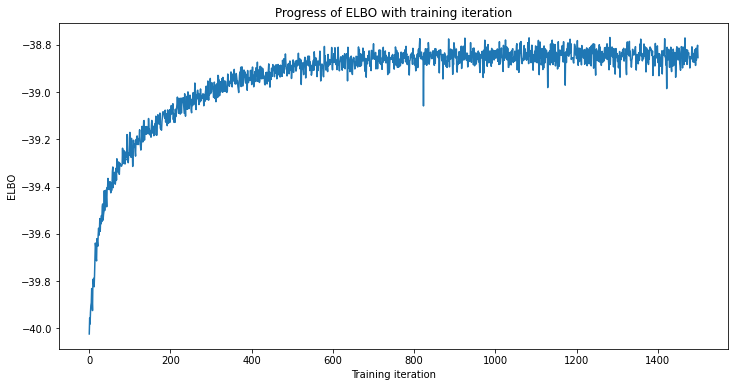

u mean estimate: 5.794486188159296
v mean estimate: 0.9667868144321733
[[ 1.13789152 -0.16554957]
 [-0.16554957  0.09750757]]


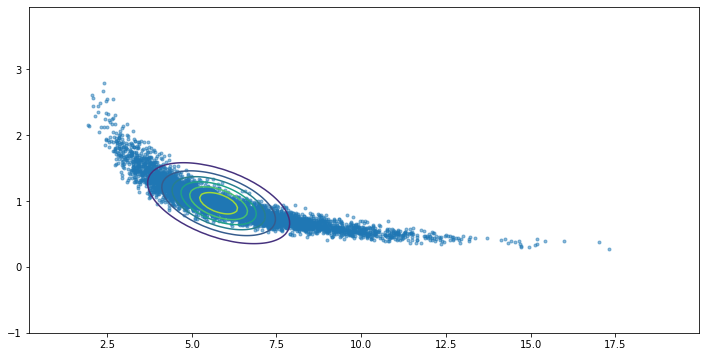

In [3]:
# Define data and the optimization problem
x = np.array([5,3,9,13,5,3,5,1,2,7,6,5,6,7,4])
N = len(x)
data = torch.tensor(x, dtype=torch.double).reshape((1, N))

u_gamma_mean = 6.
u_gamma_var = 0.5
v_gamma_mean = 0.9
v_gamma_var = 0.05
uv_gamma_cov = 0.

# mu = torch.nn.Parameter(torch.tensor([u_gamma_mean, v_gamma_mean], requires_grad=True, dtype=torch.double))
# cov = torch.nn.Parameter(torch.tensor([[u_gamma_var, 0.], [uv_gamma_cov, v_gamma_var]], requires_grad=True, dtype=torch.double))

params = torch.nn.Parameter(torch.tensor([u_gamma_mean, v_gamma_mean, u_gamma_var, uv_gamma_cov, v_gamma_var], requires_grad=True, dtype=torch.double))
opt = torch.optim.Adam([params], lr=1e-3)
M = 500
nIter = 1500

# Priors
u_prior = torch.distributions.Gamma(u_alpha, u_beta)
v_prior = torch.distributions.Gamma(v_alpha, v_beta)

def log_density(data, u, v):
    likelihood = torch.distributions.Poisson(u*v)
    return torch.sum(likelihood.log_prob(data), axis=1) + (u_prior.log_prob(u) + v_prior.log_prob(v)).flatten()

ELBOS = list()
for i in range(nIter):
    opt.zero_grad()

    # Define approximation
    mu = params[:2]
    cov = torch.zeros((2, 2), dtype=torch.double)
    cov[torch.tril_indices(2, 2, offset=0).tolist()] = params[2:]
    # q_uv = torch.distributions.MultivariateNormal(params[0], scale_tril=torch.tril(params[1]))
    q_uv = torch.distributions.MultivariateNormal(mu, scale_tril=torch.tril(cov))

    # Obtain samples
    uv = torch.clamp(q_uv.rsample([M]), 1e-8)
    u = uv[:,0].reshape((M, 1))
    v = uv[:,1].reshape((M, 1))
    
    # Compute ELBO
    ELBO = torch.mean( log_density(data, u, v) - q_uv.log_prob(uv) )
    
    # We need a minimization problem but ELBO is to be maximized
    loss = -ELBO
    loss.backward()
    ELBOS.append(ELBO.item())
    opt.step()
    
# Plotting goes here
# 1. Convergence plot
# 2. Illustration of the posterior
plt.plot(ELBOS)
plt.title("Progress of ELBO with training iteration")
plt.xlabel("Training iteration")
plt.ylabel("ELBO")
plt.show()

# Convert to np for plotting
mu = params[:2].detach().numpy()

print("u mean estimate:", mu[0])
print("v mean estimate:", mu[1])

cov = np.zeros((2, 2))
cov[np.tril_indices(2)] = params[2:].detach().numpy()
# cov = params[2:].detach().numpy()
cov[0][1] = cov[1][0]
print(cov)

ugrid = np.arange(0.2,20,0.05)
vgrid = np.arange(-1,4,0.05)
uset, vset = np.meshgrid(ugrid, vgrid)

pos = np.dstack((uset, vset))
pdf_VI = stats.multivariate_normal(mean=mu, cov=cov).pdf(pos)

# Add some Gibbs samples on top to compare
gibbs_samples = Gibbs(x, mu[0], mu[1], 5500)
plt.plot(gibbs_samples[500:,0], gibbs_samples[500:,1], '.', alpha=0.5)

# Then plot the countours
_ = plt.contour(uset, vset, pdf_VI, cmap="viridis")

## Multivariate normal approximation with half-normal prior

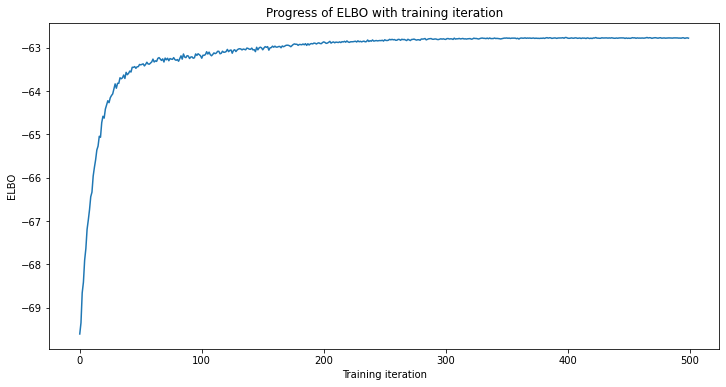

u mean estimate: 4.931313244466003
v mean estimate: 0.8026701807228251
[[ 0.56907741 -0.05425877]
 [-0.05425877  0.07863362]]


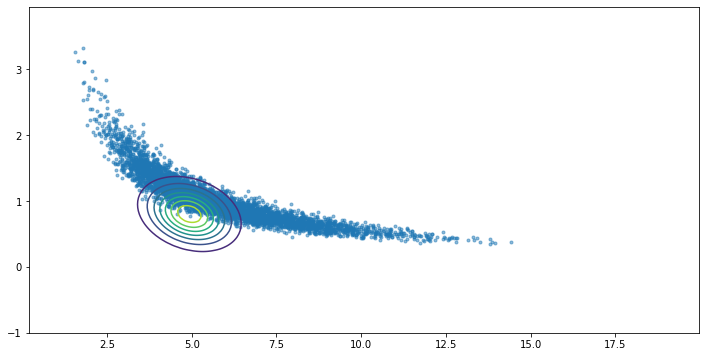

In [4]:
# Define data and the optimization problem
data = torch.tensor(x).reshape((1, N))

# Estimating mean and variance of the theoretical distributions for u and v
u_gamma_mean = 87./15.
u_gamma_var = 87./15.**2
v_gamma_mean = 84./90.
v_gamma_var = 84./90.**2
uv_gamma_cov = np.sqrt(u_gamma_var*v_gamma_var)

params = torch.nn.Parameter(torch.tensor([u_gamma_mean, v_gamma_mean, u_gamma_var, uv_gamma_cov, v_gamma_var], requires_grad=True, dtype=torch.double))
opt = torch.optim.Adam([params], lr=5e-3)
M = 1000
nIter = 500

# Priors

# From Wikipedia's Half-Normal distribution page, variance
u_prior_std = np.sqrt(u_gamma_var/(1 - 2/np.pi))
v_prior_std = np.sqrt(v_gamma_var/(1 - 2/np.pi))

u_prior = torch.distributions.HalfNormal(torch.tensor([u_prior_std]))
v_prior = torch.distributions.HalfNormal(torch.tensor([v_prior_std]))

def log_density(data, u, v):
    likelihood = torch.distributions.Poisson(u*v)
    return torch.sum(likelihood.log_prob(data), axis=1) + (u_prior.log_prob(u) + v_prior.log_prob(v)).flatten()

ELBOS = list()
for i in range(nIter):
    opt.zero_grad()

    # Define approximation
    mu = params[:2]
    cov = torch.zeros((2, 2), dtype=torch.double)
    cov[torch.tril_indices(2, 2, offset=0).tolist()] = params[2:]
    # q_uv = torch.distributions.MultivariateNormal(params[0], scale_tril=torch.tril(params[1]))
    q_uv = torch.distributions.MultivariateNormal(mu, scale_tril=torch.tril(cov))

    # Obtain samples
    uv = torch.clamp(q_uv.rsample([M]), 1e-8)
    u = uv[:,0].reshape((M, 1))
    v = uv[:,1].reshape((M, 1))
    
    # Compute ELBO
    ELBO = torch.mean( log_density(data, u, v) - q_uv.log_prob(uv) )
    
    # We need a minimization problem but ELBO is to be maximized
    loss = -ELBO
    loss.backward()
    ELBOS.append(ELBO.item())
    opt.step()
    
# Plotting goes here
# 1. Convergence plot
# 2. Illustration of the posterior
plt.plot(ELBOS)
plt.title("Progress of ELBO with training iteration")
plt.xlabel("Training iteration")
plt.ylabel("ELBO")
plt.show()

# Convert to np for plotting
mu = params[:2].detach().numpy()

print("u mean estimate:", mu[0])
print("v mean estimate:", mu[1])

cov = np.zeros((2, 2))
cov[np.tril_indices(2)] = params[2:].detach().numpy()
# cov = params[2:].detach().numpy()
cov[0][1] = cov[1][0]
print(cov)

ugrid = np.arange(0.2,20,0.05)
vgrid = np.arange(-1,4,0.05)
uset, vset = np.meshgrid(ugrid, vgrid)

pos = np.dstack((uset, vset))
pdf_VI = stats.multivariate_normal(mean=mu, cov=cov).pdf(pos)

# Add some Gibbs samples on top to compare
gibbs_samples = Gibbs(x, mu[0], mu[1], 5500)
plt.plot(gibbs_samples[500:,0], gibbs_samples[500:,1], '.', alpha=0.5)

# Then plot the countours
_ = plt.contour(uset, vset, pdf_VI, cmap="viridis")

# Problem 2: Variational autoencoder

The code below implements most parts of a **variational autoencoder for the MNIST digits data** and also downloads the data for you on the first run. We use two-dimensional representations (K=2) for ease of plotting, fully connected neural networks for all components of the model, and normal likelihood for simplicity. A better model using convolutional networks, higher-dimensional representations and more suitable likelihoods would follow the exact same general algorithm.

You are free to consult external sources (including ones that provide code) to understand the model better, but remember to mention what you looked at.

Complete the implementation by
1. Specifying the prior distribution of the latent variables as a normal distribution with zero mean and unit covariance
2. Compute the parameters of the approximation for the set of samples in the current mini-batch. Remember that the standard deviation has to be positive.
3. Form the actual approximation and obtain samples from it using .rsample()
4. Compute the ELBO, using normal likelihood with fixed standard deviation (obs_sigma). Since every data point is independent both in terms of the prior and the likelihood, it is probably easiest to write the expression for a single data point and then take the mean of those. By taking the mean instead of sum, you get numbers that are comparable over multiple batch sizes. Remember that our observations have D=784 dimensions and you need to sum over those in the log-likelihood part.

Then run the code and inspect how it works. You should be seeing ELBO improve and the mean reconstructions for the images should look somehow reasonable. If this is not the case, try to guess what is wrong and debug your code. You can also change the parameters (number of hidden layers etc) if you want to further improve the results.

In [5]:
import torch
import torch.nn as nn
import torchvision
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Set hyperparameters of the model and optimization
K = 2
obs_sigma = 0.1
batch_size = 100
numEpoch = 30
lr = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MNIST data 
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size, shuffle=True)

# Prior distribution for latent variables
p_z = torch.distributions.MultivariateNormal(torch.zeros(K).to(device), torch.eye(K).to(device))

# Encoder and decoder specifications. Both are fully connected networks, so no CNN magic here
D = 28*28
H = 40
encoder_mu = nn.Sequential(nn.Linear(D,H), nn.ReLU(),
                           nn.Linear(H,H), nn.ReLU(),
                           nn.Linear(H,K,bias=True)).to(device)
encoder_sigma = nn.Sequential(nn.Linear(D,H), nn.ReLU(),
                              nn.Linear(H,H), nn.ReLU(),
                              nn.Linear(H,K,bias=True)).to(device)
decoder = nn.Sequential(nn.Linear(K,H), nn.ReLU(),
                        nn.Linear(H,H), nn.ReLU(),
                        nn.Linear(H,D,bias=True)).to(device)

# Optimize over parameters of all networks
params = list(encoder_mu.parameters()) + list(encoder_sigma.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

loglike_sigma = obs_sigma*torch.ones(D).to(device)

def log_likelihood(data, mu):
    return torch.distributions.Normal(mu, loglike_sigma).log_prob(data).sum(axis=1)

elbos = []
for i in tqdm(range(numEpoch)):
    batches = iter(train_loader)

    epochloss = 0.
    for j in range(len(batches)):
        optimizer.zero_grad()

        # Next batch of samples
        batch_data, batch_targets = next(batches)
        x = batch_data.reshape((batch_size,-1)).to(device)
    
        # Form parameters of approximation
        mu_approx = encoder_mu(x)
        sigma_approx = encoder_sigma(x)
        
        # Sample from approximation
        q_z_x = torch.distributions.MultivariateNormal(mu_approx, torch.diag_embed(torch.clamp(sigma_approx, 1e-8)))
        z = q_z_x.rsample([100])

        # Find mean parameters of observed data
        x_mean = decoder(z).mean(axis=0)
        # ELBO
        ELBO_for_one_point = log_likelihood(x, x_mean) + p_z.log_prob(z) - q_z_x.log_prob(z)
        loss = - torch.mean(ELBO_for_one_point)
        epochloss += loss
    
        loss.backward()
        optimizer.step()
    elbos.append( (-epochloss/len(batches)).cpu().detach().numpy() )

  0%|          | 0/30 [00:00<?, ?it/s]

Below you find code for making the plots you need. Feel free to improve the plots if you want to show something else, for example illustrate the variance of the representations.

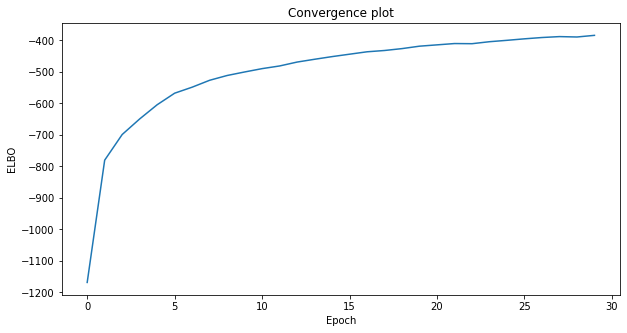

In [6]:
# Convergence plot
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(elbos)
plt.title("Convergence plot")
plt.xlabel('Epoch')
_ = plt.ylabel('ELBO')
plt.show()

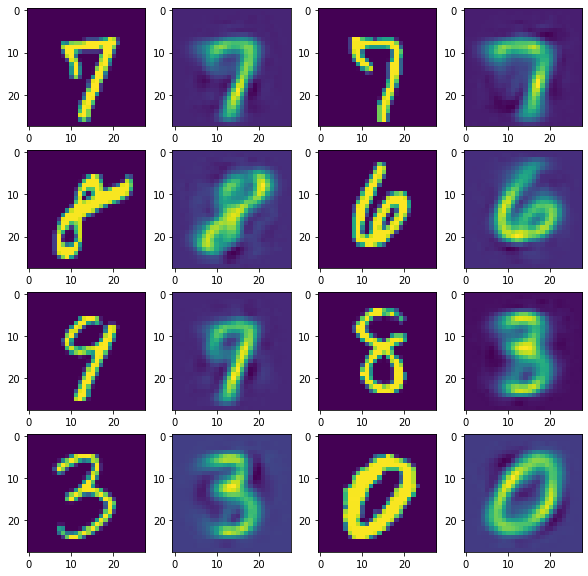

In [7]:
# Illustration of some samples, showing the mean of the reconstruction
plt.rcParams["figure.figsize"] = (10, 10)
# Note: Uses the values from the last iteration of the algorithm, so this shows some
# examples in the last minibatch
x = batch_data.reshape((batch_size,-1)).to(device)
for sam in range(8):
    plt.subplot(4,4,sam*2+1)
    plt.imshow(x[sam,:].cpu().reshape(28,28))

    plt.subplot(4,4,sam*2+2)
    plt.imshow(x_mean[sam,:].cpu().detach().reshape(28,28))
plt.show()
    
    
# 2D visualization of the data in the latent space
# Do this for 10,000 examples, forming a batch of those and computing q() for them
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=10000, shuffle=True)

batches_viz = iter(train_loader)
batch_data_viz, batch_targets_viz = next(batches_viz)
x_viz = batch_data_viz.reshape((10000,-1)).to(device)

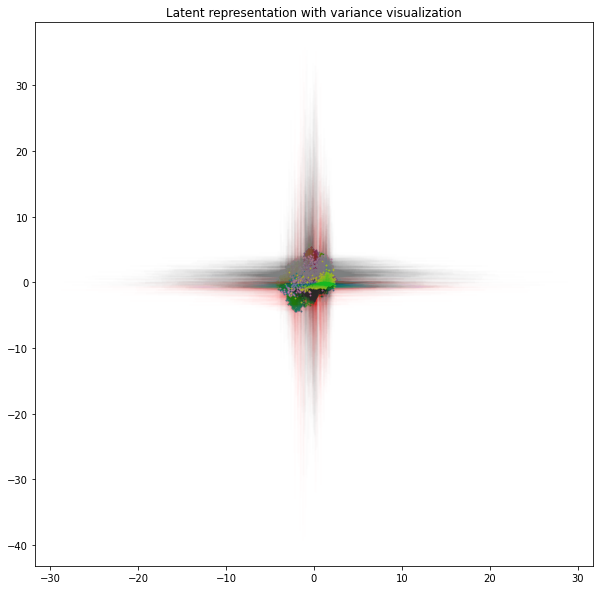

In [8]:
# Find the parameters of the approximation in the same way as during optimization
mu_approx = encoder_mu(x_viz)
sigma_approx = encoder_sigma(x_viz)

plt.rcParams["figure.figsize"] = (10, 10)
for c in range(10):
    plt.plot(mu_approx.cpu().detach()[batch_targets_viz==c,0], mu_approx.cpu().detach()[batch_targets_viz==c,1], '.', alpha=0.6, markersize=2.0)
    # Perhaps add here some way of illustrating the variance of the embedding
    #plt.plot(...)
    plt.errorbar(mu_approx.cpu().detach()[batch_targets_viz==c,0], mu_approx.cpu().detach()[batch_targets_viz==c,1], 
                xerr=sigma_approx.cpu().detach()[batch_targets_viz==c,0], yerr=sigma_approx.cpu().detach()[batch_targets_viz==c,1], alpha=5e-3)
    # plt.show()

plt.title("Latent representation with variance visualization")
plt.show()

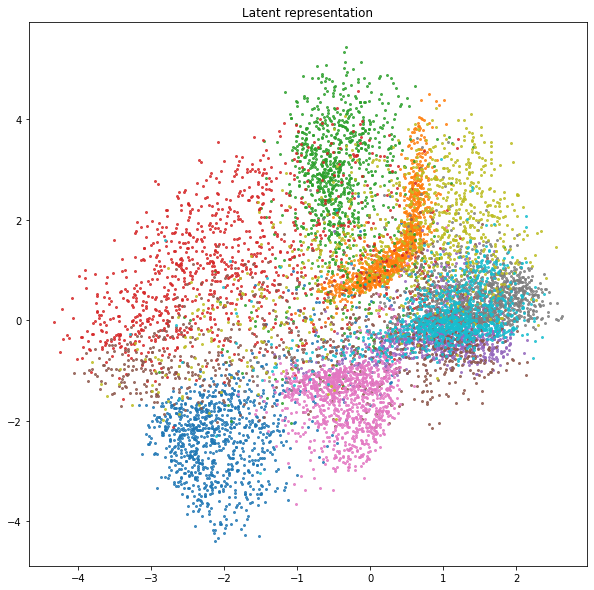

In [9]:
plt.rcParams["figure.figsize"] = (10, 10)
for c in range(10):
    plt.plot(mu_approx.cpu().detach()[batch_targets_viz==c,0], mu_approx.cpu().detach()[batch_targets_viz==c,1], '.', alpha=0.8, markersize=4.0)
    # Perhaps add here some way of illustrating the variance of the embedding
    #plt.plot(...)
    # plt.show()

plt.title("Latent representation")
plt.show()

# Problem 3: Normalizing flows as variational approximation

Read through the paper "Sylvester Normalizing Flows for Variational Inference" by van den Berg et al. (UAI, 2018) available at http://auai.org/uai2018/proceedings/papers/156.pdf and watch the 15-minute conference precentation explaining the paper available at https://www.youtube.com/watch?v=VeYyUcIDVHI&ab_channel=UAI2018. Note that this is not the first paper tha proposed using normalising flows for variational inference, but I chose this because it is easier to read and understand.

Answer to the following questions. If you use the notebook to write the answers, please use the 'Markdown' mode for the cell and write equations in latex notation inside dollar symbols. Hand-written answers are also fine, and illustrations that help understand the concepts are appreciated.
1. Explain briefly **how the Sylvester flow works** -- explain it also using mathematical notation and tell the main characteristics. No need to go through any proofs or the details for different special cases, but focus on explaining the main principle.
2. Tell how we can **use the flow as variational approximation**, explaning it in words while also providing the details. You can either describe the details mathematically or write python-like pseudocode where you explain how specific quantities are being transformed and what do we optimize for etc.
3. What do you think the result would be if you applied this for our gamma-Poisson problem studied throughout the exercises? What would the resulting posterior approximation most likely be? Do you see challenges in using this for that problem?

In [10]:
# Function to introduce the mathematical derivations
def show_img(path):
    img = mpimg.imread(path)

    plt.figure(figsize = (20,20))
    plt.imshow(img)
    return

NOTE: All visualizations and mathematical expressions are taken from the provided paper. I will also assume that for this exercise the general background on normalizing flows that we covered in the lectures is known

